In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from sklearn.cluster import KMeans

DATA_DIR = "../content/processed_data"
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
CLASSES = ["Hemorrhagic", "Ischemic", "Tumor"]

print(f"Using device: {DEVICE}")

Using device: cuda:1


## ResUNet Architecture

### Key Components:
1. **Residual Block**: Conv + BN + ReLU + Conv + BN + Skip Connection
2. **Encoder**: Progressive downsampling with residual blocks
3. **Bridge**: Deepest layer with residual connections
4. **Decoder**: Progressive upsampling with skip connections from encoder
5. **Output**: 1-channel binary mask with sigmoid activation

In [56]:
class ResidualBlock(nn.Module):
    """Residual block with skip connection"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Skip connection - adjust dimensions if needed
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = self.skip(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity  # Residual connection
        out = self.relu(out)
        
        return out

print("Residual Block defined.")

Residual Block defined.


In [57]:
class ResUNet(nn.Module):
    """Residual U-Net for medical image segmentation"""
    def __init__(self, in_channels=3, out_channels=1):
        super(ResUNet, self).__init__()
        
        # Initial convolution
        self.input_layer = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        # Encoder (Downsampling path)
        self.encoder1 = ResidualBlock(64, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.encoder2 = ResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.encoder3 = ResidualBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.encoder4 = ResidualBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bridge (Bottleneck)
        self.bridge = ResidualBlock(512, 1024)
        
        # Decoder (Upsampling path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = ResidualBlock(1024, 512)  # 1024 = 512 (upconv) + 512 (skip)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = ResidualBlock(512, 256)  # 512 = 256 + 256
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = ResidualBlock(256, 128)  # 256 = 128 + 128
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = ResidualBlock(128, 64)  # 128 = 64 + 64
        
        # Output layer
        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Encoder
        x = self.input_layer(x)
        
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)
        
        enc2 = self.encoder2(x)
        x = self.pool2(enc2)
        
        enc3 = self.encoder3(x)
        x = self.pool3(enc3)
        
        enc4 = self.encoder4(x)
        x = self.pool4(enc4)
        
        # Bridge
        x = self.bridge(x)
        
        # Decoder with skip connections
        x = self.upconv4(x)
        x = torch.cat([x, enc4], dim=1)  # Skip connection
        x = self.decoder4(x)
        
        x = self.upconv3(x)
        x = torch.cat([x, enc3], dim=1)
        x = self.decoder3(x)
        
        x = self.upconv2(x)
        x = torch.cat([x, enc2], dim=1)
        x = self.decoder2(x)
        
        x = self.upconv1(x)
        x = torch.cat([x, enc1], dim=1)
        x = self.decoder1(x)
        
        # Output
        x = self.output_layer(x)
        return torch.sigmoid(x)

# Initialize model
resunet_model = ResUNet().to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in resunet_model.parameters())
trainable_params = sum(p.numel() for p in resunet_model.parameters() if p.requires_grad)

print(f"ResUNet Model Initialized")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

ResUNet Model Initialized
Total Parameters: 32,473,089
Trainable Parameters: 32,473,089


## Pseudo-Mask Generation

Using K-Means clustering for weakly-supervised segmentation:
- **Hemorrhagic & Tumor**: Target bright clusters (hyperdense regions)
- **Ischemic**: Target dark clusters (hypodense regions)

In [58]:
def generate_pseudo_mask(image_tensor, label_idx):
    """
    Auto-generates segmentation mask using local adaptive thresholding + asymmetry.
    Weakly-supervised approach using only image-level labels.
    """
    # Convert tensor to numpy
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    
    # Denormalize
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    gray = cv2.cvtColor(np.float32(img_np), cv2.COLOR_RGB2GRAY)
    gray_uint8 = (gray * 255).astype(np.uint8)
    
    # Extract brain tissue
    brain_mask = gray > 0.05
    
    if np.sum(brain_mask) < 100:
        return torch.zeros((1, 224, 224), dtype=torch.float32)
    
    # Method 1: Local Adaptive Thresholding (works well for contrast variations)
    if label_idx == 1:  # Ischemic - look for dark regions
        # Adaptive threshold for dark regions
        adaptive_mask = cv2.adaptiveThreshold(
            gray_uint8, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, blockSize=15, C=10
        )
    else:  # Hemorrhagic or Tumor - look for bright regions
        # Adaptive threshold for bright regions
        adaptive_mask = cv2.adaptiveThreshold(
            gray_uint8, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY, blockSize=15, C=10
        )
    
    adaptive_mask = (adaptive_mask > 0) & brain_mask
    
    # Method 2: Hemisphere Asymmetry Detection
    h, w = gray.shape
    midpoint = w // 2
    left_half = gray[:, :midpoint]
    right_half = np.fliplr(gray[:, midpoint:])
    
    # Resize to match if different sizes
    if left_half.shape[1] != right_half.shape[1]:
        min_width = min(left_half.shape[1], right_half.shape[1])
        left_half = left_half[:, :min_width]
        right_half = right_half[:, :min_width]
    
    # Calculate absolute difference
    asymmetry = np.abs(left_half - right_half)
    
    # Threshold asymmetry
    asym_threshold = asymmetry.mean() + 1.0 * asymmetry.std()
    asymmetry_mask = np.zeros_like(gray)
    asymmetry_mask[:, :midpoint] = asymmetry > asym_threshold
    
    # Method 3: Statistical outliers
    brain_pixels = gray[brain_mask]
    mean_val = brain_pixels.mean()
    std_val = brain_pixels.std()
    
    if label_idx == 1:  # Ischemic
        outlier_mask = (gray < mean_val - 0.8 * std_val) & brain_mask
    else:  # Hemorrhagic or Tumor
        outlier_mask = (gray > mean_val + 0.8 * std_val) & brain_mask
    
    # Combine all methods
    combined_mask = adaptive_mask.astype(float) + asymmetry_mask.astype(float) + outlier_mask.astype(float)
    combined_mask = (combined_mask >= 2).astype(np.uint8)  # Need at least 2 methods to agree
    
    # Morphological cleanup
    kernel = np.ones((3, 3), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    
    # Connected component analysis - keep reasonable-sized regions
    num_labels, labels_im = cv2.connectedComponents(combined_mask)
    
    final_mask = np.zeros_like(gray)
    if num_labels > 1:
        for i in range(1, num_labels):
            component = (labels_im == i)
            size = np.sum(component)
            
            # Keep components between 0.5% and 30% of brain area
            brain_area = np.sum(brain_mask)
            if 0.005 * brain_area < size < 0.30 * brain_area:
                final_mask[component] = 1
    
    # If no mask found, fall back to simple percentile method
    if np.sum(final_mask) < 50:
        if label_idx == 1:
            percentile_val = np.percentile(brain_pixels, 10)
            final_mask = ((gray < percentile_val) & brain_mask).astype(float)
        else:
            percentile_val = np.percentile(brain_pixels, 90)
            final_mask = ((gray > percentile_val) & brain_mask).astype(float)
        
        # Clean up fallback mask
        final_mask = cv2.morphologyEx(final_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel)
        final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
    
    # Final smoothing
    final_mask = cv2.GaussianBlur(final_mask.astype(np.float32), (5, 5), 0)
    final_mask = (final_mask > 0.3).astype(np.float32)
    
    return torch.tensor(final_mask, dtype=torch.float32).unsqueeze(0)

print("Pseudo-Mask Generator Ready.")

Pseudo-Mask Generator Ready.


## Dataset Preparation

In [59]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class NeuroDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_map = {name: i for i, name in enumerate(CLASSES)}
        
        # Load all images
        for cls_name in CLASSES:
            cls_folder = os.path.join(root_dir, cls_name)
            if not os.path.exists(cls_folder):
                continue
            
            fnames = [f for f in os.listdir(cls_folder) if f.endswith(('.jpg', '.png'))]
            for f in fnames:
                self.samples.append((os.path.join(cls_folder, f), self.class_map[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Initialize dataset
full_dataset = NeuroDataset(DATA_DIR, transform=transform)
print(f"Dataset Loaded: {len(full_dataset)} images")
print(f"Classes: {CLASSES}")

Dataset Loaded: 455 images
Classes: ['Hemorrhagic', 'Ischemic', 'Tumor']


## Training ResUNet

### Hybrid Loss Function:
Combining multiple loss functions for better segmentation:
1. **Binary Cross-Entropy (BCE)**: Pixel-wise classification
2. **Dice Loss**: Overlap-based metric for imbalanced masks

In [60]:
class DiceLoss(nn.Module):
    """Dice Loss for segmentation"""
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = pred.contiguous().view(-1)
        target = target.contiguous().view(-1)
        
        intersection = (pred * target).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        
        return 1 - dice

class HybridLoss(nn.Module):
    """Combined BCE + Dice Loss"""
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(HybridLoss, self).__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
    
    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        dice_loss = self.dice(pred, target)
        return self.bce_weight * bce_loss + self.dice_weight * dice_loss

print("Hybrid Loss Function Ready.")

Hybrid Loss Function Ready.


In [61]:
def train_resunet(model, dataset, epochs=10, lr=0.001):
    """
    Train ResUNet with pseudo-labels
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = HybridLoss(bce_weight=0.5, dice_weight=0.5)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.5, patience=2)
    
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    
    history = {'loss': [], 'bce_loss': [], 'dice_loss': []}
    
    print("\n" + "="*60)
    print("Starting ResUNet Training (Weakly-Supervised)")
    print("="*60 + "\n")
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        epoch_bce = 0.0
        epoch_dice = 0.0
        
        progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        
        for images, labels in progress_bar:
            images = images.to(DEVICE)
            
            # Generate pseudo-masks on-the-fly
            masks = []
            for i in range(len(images)):
                mask = generate_pseudo_mask(images[i], labels[i].item())
                masks.append(mask)
            masks = torch.stack(masks).to(DEVICE)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            
            # Calculate losses
            loss = criterion(outputs, masks)
            bce_loss = nn.BCELoss()(outputs, masks)
            dice_loss = DiceLoss()(outputs, masks)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            epoch_bce += bce_loss.item()
            epoch_dice += dice_loss.item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'BCE': f"{bce_loss.item():.4f}",
                'Dice': f"{dice_loss.item():.4f}"
            })
        
        # Calculate average losses
        avg_loss = epoch_loss / len(loader)
        avg_bce = epoch_bce / len(loader)
        avg_dice = epoch_dice / len(loader)
        
        history['loss'].append(avg_loss)
        history['bce_loss'].append(avg_bce)
        history['dice_loss'].append(avg_dice)
        
        # Learning rate scheduling
        scheduler.step(avg_loss)
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Total Loss: {avg_loss:.4f}")
        print(f"  BCE Loss: {avg_bce:.4f}")
        print(f"  Dice Loss: {avg_dice:.4f}")
        print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}\n")
    
    # Save model
    save_path = "../models/resunet_segmentation_model.pth"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print(f"\nModel saved to: {save_path}")
    
    return model, history

print("Training function ready.")

Training function ready.


In [62]:
# Train the model
trained_model, training_history = train_resunet(resunet_model, full_dataset, epochs=EPOCHS, lr=LEARNING_RATE)


Starting ResUNet Training (Weakly-Supervised)



Epoch 1/20: 100%|██████████| 29/29 [00:12<00:00,  2.36it/s, Loss=0.3019, BCE=0.1399, Dice=0.4640]



Epoch 1 Summary:
  Total Loss: 0.4173
  BCE Loss: 0.2369
  Dice Loss: 0.5978
  Learning Rate: 0.001000



Epoch 2/20: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s, Loss=0.2489, BCE=0.1449, Dice=0.3530]



Epoch 2 Summary:
  Total Loss: 0.3086
  BCE Loss: 0.1528
  Dice Loss: 0.4645
  Learning Rate: 0.001000



Epoch 3/20: 100%|██████████| 29/29 [00:12<00:00,  2.35it/s, Loss=0.2135, BCE=0.0999, Dice=0.3271]



Epoch 3 Summary:
  Total Loss: 0.2755
  BCE Loss: 0.1458
  Dice Loss: 0.4051
  Learning Rate: 0.001000



Epoch 4/20: 100%|██████████| 29/29 [00:12<00:00,  2.34it/s, Loss=0.2311, BCE=0.1198, Dice=0.3424]



Epoch 4 Summary:
  Total Loss: 0.2425
  BCE Loss: 0.1315
  Dice Loss: 0.3535
  Learning Rate: 0.001000



Epoch 5/20: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, Loss=0.1718, BCE=0.0883, Dice=0.2553]



Epoch 5 Summary:
  Total Loss: 0.2372
  BCE Loss: 0.1321
  Dice Loss: 0.3424
  Learning Rate: 0.001000



Epoch 6/20: 100%|██████████| 29/29 [00:12<00:00,  2.27it/s, Loss=0.2002, BCE=0.1236, Dice=0.2768]



Epoch 6 Summary:
  Total Loss: 0.2195
  BCE Loss: 0.1251
  Dice Loss: 0.3139
  Learning Rate: 0.001000



Epoch 7/20: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, Loss=0.2501, BCE=0.1371, Dice=0.3631]



Epoch 7 Summary:
  Total Loss: 0.2199
  BCE Loss: 0.1243
  Dice Loss: 0.3155
  Learning Rate: 0.001000



Epoch 8/20: 100%|██████████| 29/29 [00:13<00:00,  2.23it/s, Loss=0.1913, BCE=0.1192, Dice=0.2634]



Epoch 8 Summary:
  Total Loss: 0.2214
  BCE Loss: 0.1267
  Dice Loss: 0.3160
  Learning Rate: 0.001000



Epoch 9/20: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s, Loss=0.2064, BCE=0.1058, Dice=0.3069]



Epoch 9 Summary:
  Total Loss: 0.2084
  BCE Loss: 0.1178
  Dice Loss: 0.2991
  Learning Rate: 0.001000



Epoch 10/20: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, Loss=0.2160, BCE=0.1385, Dice=0.2935]



Epoch 10 Summary:
  Total Loss: 0.2101
  BCE Loss: 0.1214
  Dice Loss: 0.2988
  Learning Rate: 0.001000



Epoch 11/20: 100%|██████████| 29/29 [00:12<00:00,  2.24it/s, Loss=0.1675, BCE=0.0968, Dice=0.2382]



Epoch 11 Summary:
  Total Loss: 0.2042
  BCE Loss: 0.1171
  Dice Loss: 0.2914
  Learning Rate: 0.001000



Epoch 12/20: 100%|██████████| 29/29 [00:12<00:00,  2.34it/s, Loss=0.1649, BCE=0.0958, Dice=0.2341]



Epoch 12 Summary:
  Total Loss: 0.2036
  BCE Loss: 0.1170
  Dice Loss: 0.2903
  Learning Rate: 0.001000



Epoch 13/20: 100%|██████████| 29/29 [00:12<00:00,  2.37it/s, Loss=0.1723, BCE=0.1134, Dice=0.2312]



Epoch 13 Summary:
  Total Loss: 0.1946
  BCE Loss: 0.1129
  Dice Loss: 0.2764
  Learning Rate: 0.001000



Epoch 14/20: 100%|██████████| 29/29 [00:12<00:00,  2.39it/s, Loss=0.1920, BCE=0.1006, Dice=0.2835]



Epoch 14 Summary:
  Total Loss: 0.1912
  BCE Loss: 0.1120
  Dice Loss: 0.2704
  Learning Rate: 0.001000



Epoch 15/20: 100%|██████████| 29/29 [00:12<00:00,  2.37it/s, Loss=0.2103, BCE=0.1591, Dice=0.2615]



Epoch 15 Summary:
  Total Loss: 0.1851
  BCE Loss: 0.1067
  Dice Loss: 0.2634
  Learning Rate: 0.001000



Epoch 16/20: 100%|██████████| 29/29 [00:12<00:00,  2.36it/s, Loss=0.1308, BCE=0.0705, Dice=0.1912]



Epoch 16 Summary:
  Total Loss: 0.1825
  BCE Loss: 0.1061
  Dice Loss: 0.2588
  Learning Rate: 0.001000



Epoch 17/20: 100%|██████████| 29/29 [00:12<00:00,  2.37it/s, Loss=0.1506, BCE=0.0782, Dice=0.2230]



Epoch 17 Summary:
  Total Loss: 0.1819
  BCE Loss: 0.1052
  Dice Loss: 0.2587
  Learning Rate: 0.001000



Epoch 18/20: 100%|██████████| 29/29 [00:12<00:00,  2.36it/s, Loss=0.2120, BCE=0.0927, Dice=0.3313]



Epoch 18 Summary:
  Total Loss: 0.1814
  BCE Loss: 0.1041
  Dice Loss: 0.2588
  Learning Rate: 0.001000



Epoch 19/20: 100%|██████████| 29/29 [00:12<00:00,  2.36it/s, Loss=0.1946, BCE=0.1656, Dice=0.2236]



Epoch 19 Summary:
  Total Loss: 0.1796
  BCE Loss: 0.1067
  Dice Loss: 0.2526
  Learning Rate: 0.001000



Epoch 20/20: 100%|██████████| 29/29 [00:12<00:00,  2.36it/s, Loss=0.1295, BCE=0.0699, Dice=0.1891]


Epoch 20 Summary:
  Total Loss: 0.1720
  BCE Loss: 0.1009
  Dice Loss: 0.2432
  Learning Rate: 0.001000


Model saved to: ../models/resunet_segmentation_model.pth


## Training Visualization

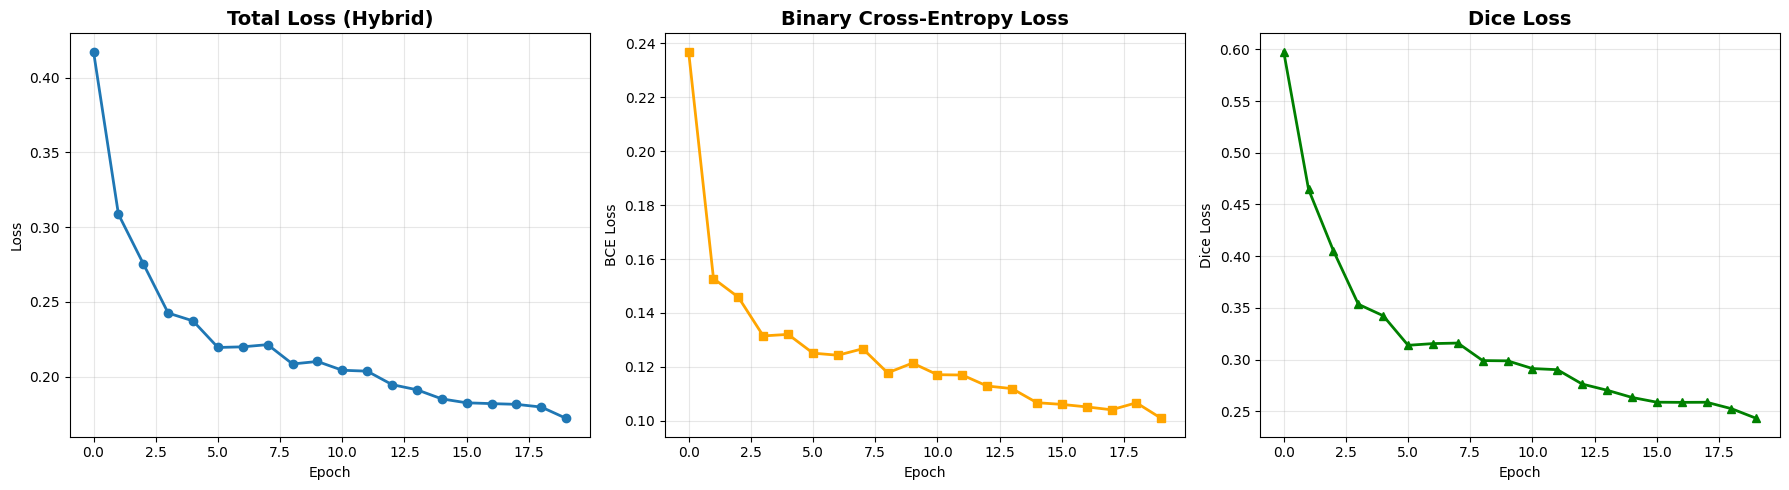

In [63]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total Loss
axes[0].plot(training_history['loss'], marker='o', linewidth=2)
axes[0].set_title('Total Loss (Hybrid)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

# BCE Loss
axes[1].plot(training_history['bce_loss'], marker='s', color='orange', linewidth=2)
axes[1].set_title('Binary Cross-Entropy Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('BCE Loss')
axes[1].grid(True, alpha=0.3)

# Dice Loss
axes[2].plot(training_history['dice_loss'], marker='^', color='green', linewidth=2)
axes[2].set_title('Dice Loss', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Dice Loss')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Segmentation Visualization

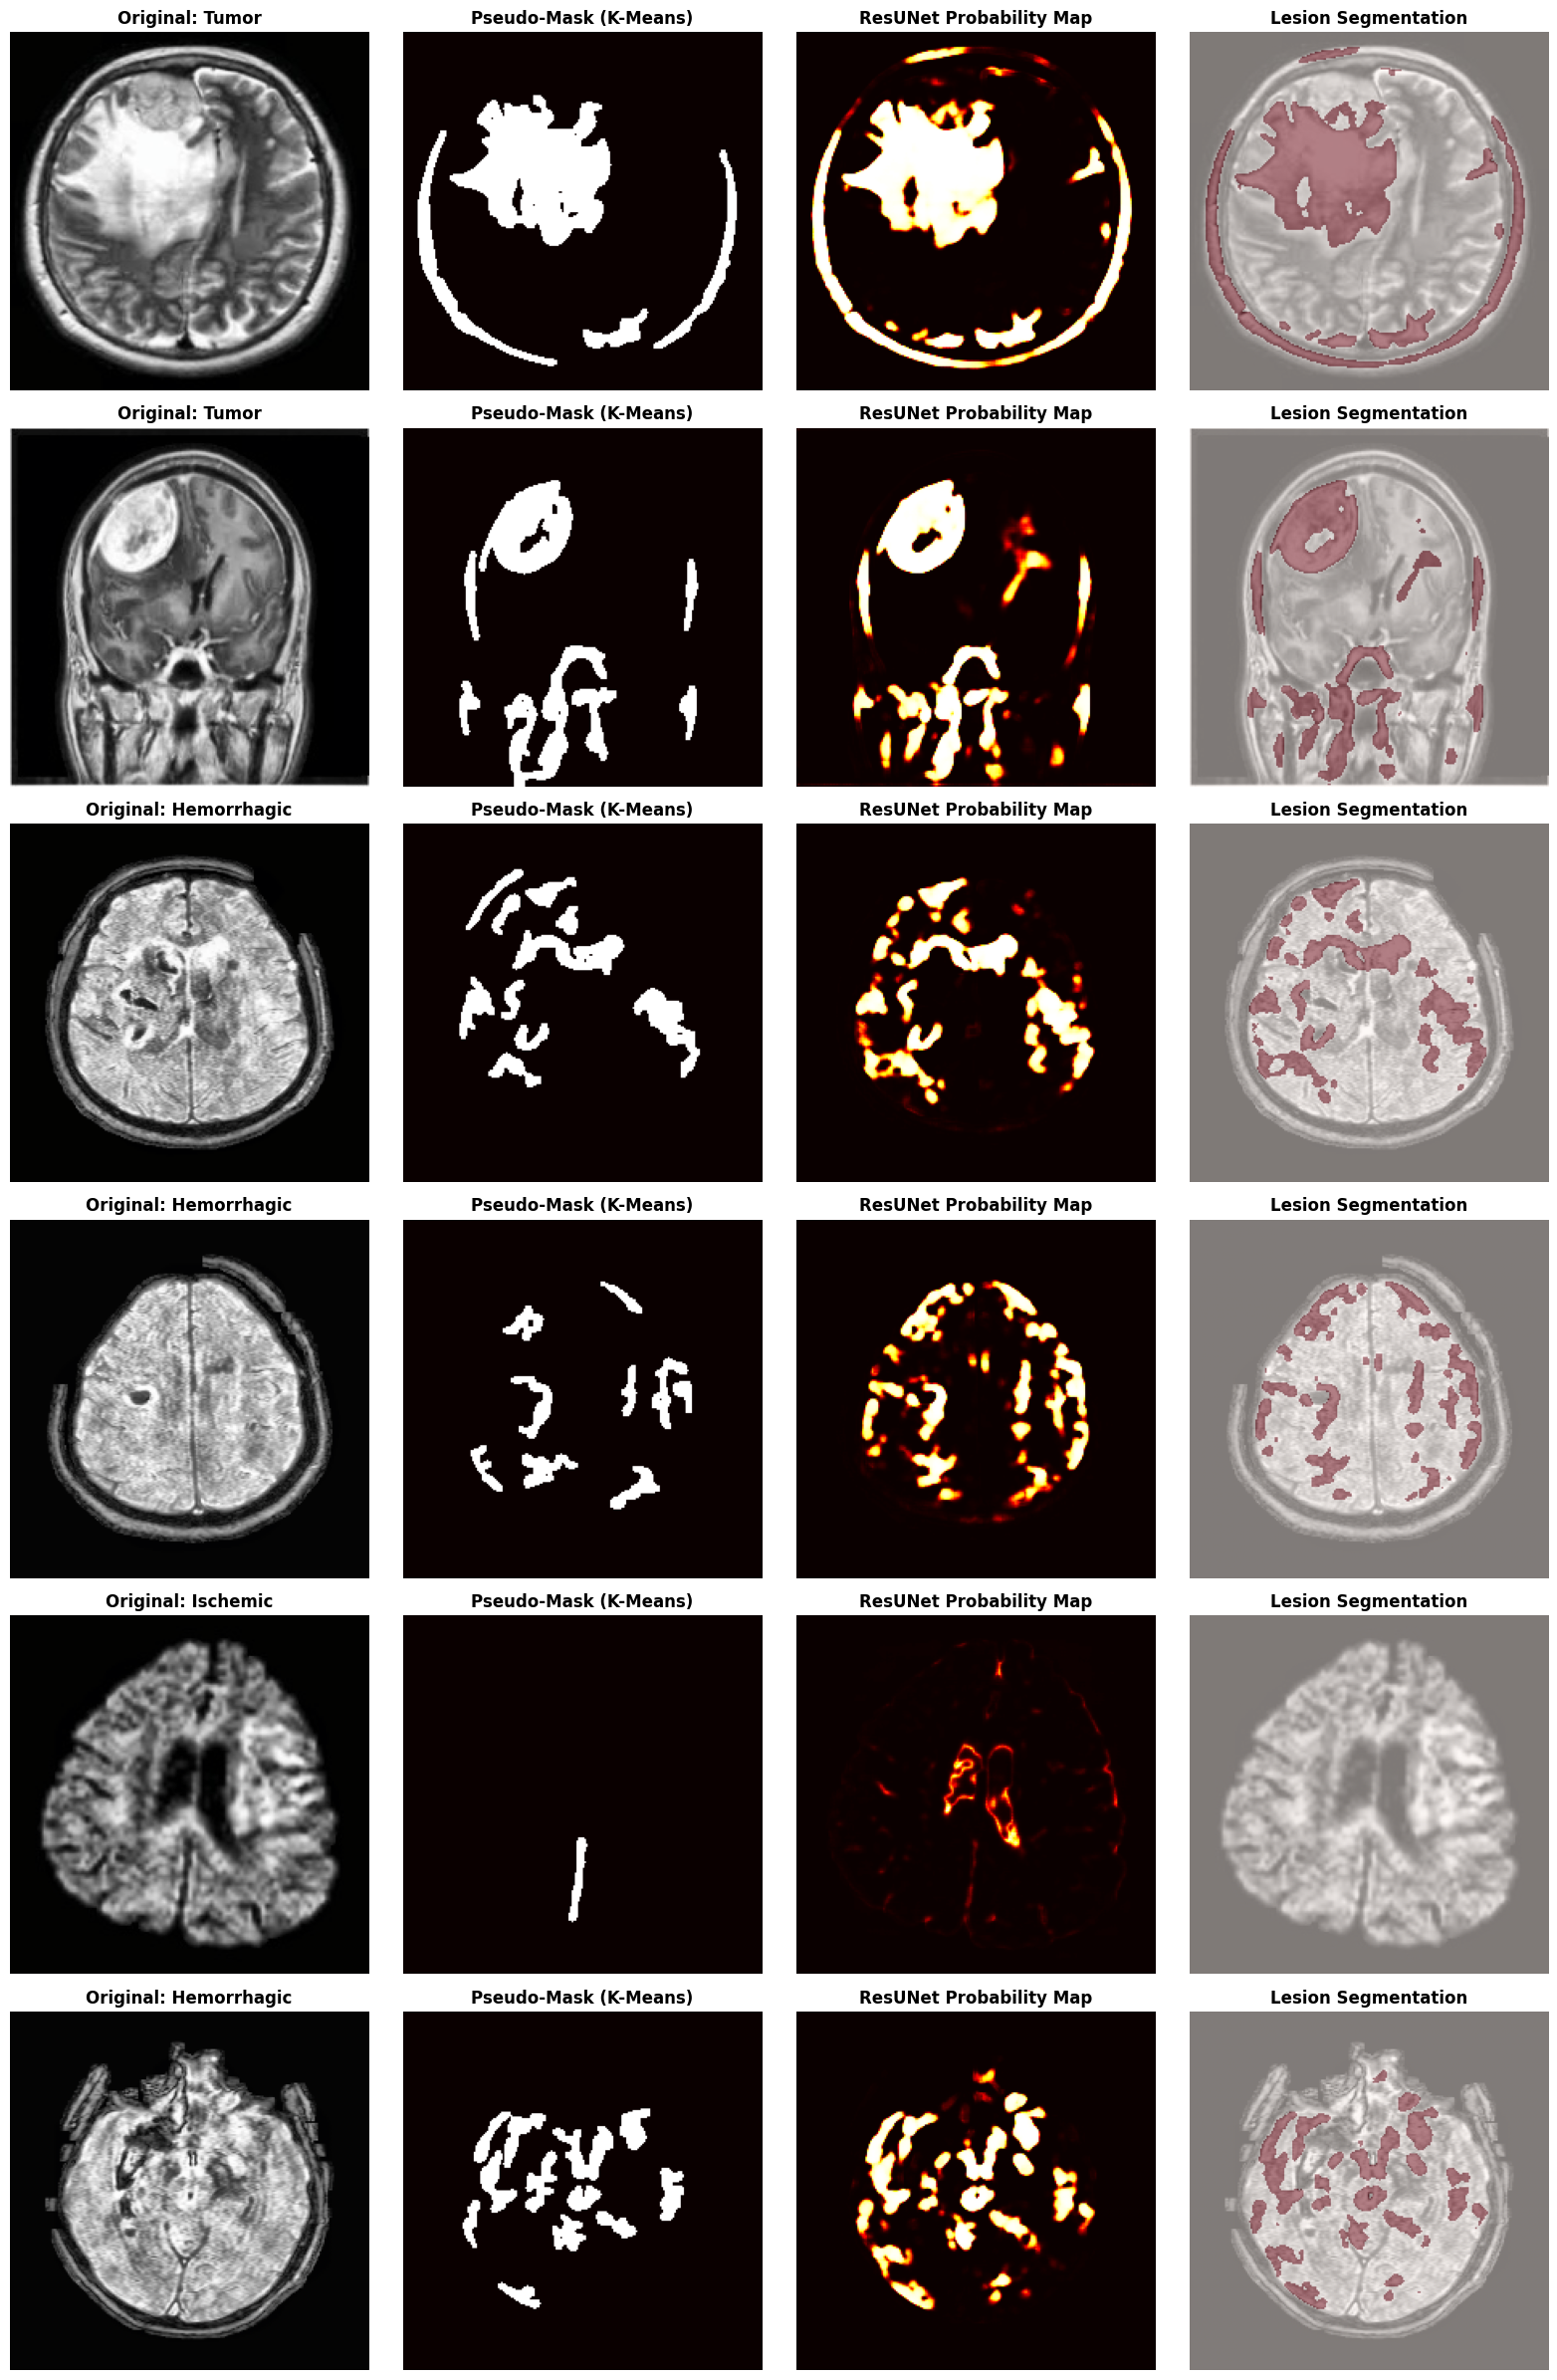

In [67]:
def visualize_resunet_results(model, dataset, num_samples=6):
    """
    Visualize ResUNet segmentation results
    """
    model.eval()
    
    # Sample random images
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))
    
    for i, idx in enumerate(indices):
        image_tensor, label_idx = dataset[idx]
        input_tensor = image_tensor.unsqueeze(0).to(DEVICE)
        
        # Predict mask
        with torch.no_grad():
            pred_mask = model(input_tensor)
            pred_mask = pred_mask.cpu().squeeze().numpy()
        
        # Generate pseudo-mask for comparison
        pseudo_mask = generate_pseudo_mask(image_tensor, label_idx).squeeze().numpy()
        
        # Threshold predictions
        pred_mask_bin = (pred_mask > 0.5).astype(np.float32)
        
        # Denormalize image
        img_disp = image_tensor.permute(1, 2, 0).numpy()
        img_disp = img_disp * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_disp = np.clip(img_disp, 0, 1)
        
        # Plot columns
        # 1. Original Image
        axes[i, 0].imshow(img_disp)
        axes[i, 0].set_title(f"Original: {CLASSES[label_idx]}", fontweight='bold')
        axes[i, 0].axis('off')
        
        # 2. Pseudo-Mask (K-Means)
        axes[i, 1].imshow(pseudo_mask, cmap='hot')
        axes[i, 1].set_title("Pseudo-Mask (K-Means)", fontweight='bold')
        axes[i, 1].axis('off')
        
        # 3. ResUNet Prediction
        axes[i, 2].imshow(pred_mask, cmap='hot')
        axes[i, 2].set_title("ResUNet Probability Map", fontweight='bold')
        axes[i, 2].axis('off')
        
        # 4. Overlay
        axes[i, 3].imshow(img_disp)
        axes[i, 3].imshow(pred_mask_bin, cmap='Reds', alpha=0.5)
        axes[i, 3].set_title("Lesion Segmentation", fontweight='bold')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize results
visualize_resunet_results(trained_model, full_dataset, num_samples=6)

## Quantitative Evaluation

In [65]:
def calculate_metrics(pred_mask, true_mask, threshold=0.5):
    """
    Calculate segmentation metrics
    """
    pred = (pred_mask > threshold).astype(np.float32).flatten()
    true = true_mask.flatten()
    
    # Dice Coefficient
    intersection = np.sum(pred * true)
    dice = (2. * intersection) / (np.sum(pred) + np.sum(true) + 1e-8)
    
    # IoU (Intersection over Union)
    union = np.sum(pred) + np.sum(true) - intersection
    iou = intersection / (union + 1e-8)
    
    # Pixel Accuracy
    accuracy = np.sum(pred == true) / len(pred)
    
    return dice, iou, accuracy

def evaluate_model(model, dataset, num_samples=100):
    """
    Evaluate model on random samples
    """
    model.eval()
    
    metrics_per_class = {cls: {'dice': [], 'iou': [], 'acc': []} for cls in CLASSES}
    
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    print("Evaluating ResUNet...")
    for idx in tqdm(indices):
        image_tensor, label_idx = dataset[idx]
        input_tensor = image_tensor.unsqueeze(0).to(DEVICE)
        
        # Predict
        with torch.no_grad():
            pred_mask = model(input_tensor).cpu().squeeze().numpy()
        
        # Generate pseudo ground truth
        true_mask = generate_pseudo_mask(image_tensor, label_idx).squeeze().numpy()
        
        # Calculate metrics
        dice, iou, acc = calculate_metrics(pred_mask, true_mask)
        
        class_name = CLASSES[label_idx]
        metrics_per_class[class_name]['dice'].append(dice)
        metrics_per_class[class_name]['iou'].append(iou)
        metrics_per_class[class_name]['acc'].append(acc)
    
    # Print results
    print("\n" + "="*70)
    print("ResUNet Evaluation Results (vs Pseudo-Masks)")
    print("="*70)
    
    for cls in CLASSES:
        print(f"\n{cls}:")
        print(f"  Dice Coefficient: {np.mean(metrics_per_class[cls]['dice']):.4f} ± {np.std(metrics_per_class[cls]['dice']):.4f}")
        print(f"  IoU: {np.mean(metrics_per_class[cls]['iou']):.4f} ± {np.std(metrics_per_class[cls]['iou']):.4f}")
        print(f"  Pixel Accuracy: {np.mean(metrics_per_class[cls]['acc']):.4f} ± {np.std(metrics_per_class[cls]['acc']):.4f}")
    
    # Overall metrics
    all_dice = [v for cls in CLASSES for v in metrics_per_class[cls]['dice']]
    all_iou = [v for cls in CLASSES for v in metrics_per_class[cls]['iou']]
    all_acc = [v for cls in CLASSES for v in metrics_per_class[cls]['acc']]
    
    print(f"\nOverall:")
    print(f"  Dice Coefficient: {np.mean(all_dice):.4f} ± {np.std(all_dice):.4f}")
    print(f"  IoU: {np.mean(all_iou):.4f} ± {np.std(all_iou):.4f}")
    print(f"  Pixel Accuracy: {np.mean(all_acc):.4f} ± {np.std(all_acc):.4f}")
    print("="*70 + "\n")
    
    return metrics_per_class

# Evaluate
evaluation_metrics = evaluate_model(trained_model, full_dataset, num_samples=100)

Evaluating ResUNet...


100%|██████████| 100/100 [00:01<00:00, 63.04it/s]


ResUNet Evaluation Results (vs Pseudo-Masks)

Hemorrhagic:
  Dice Coefficient: 0.8335 ± 0.0560
  IoU: 0.7184 ± 0.0820
  Pixel Accuracy: 0.9725 ± 0.0079

Ischemic:
  Dice Coefficient: 0.0047 ± 0.0104
  IoU: 0.0024 ± 0.0053
  Pixel Accuracy: 0.9812 ± 0.0160

Tumor:
  Dice Coefficient: 0.8328 ± 0.0790
  IoU: 0.7207 ± 0.1063
  Pixel Accuracy: 0.9634 ± 0.0181

Overall:
  Dice Coefficient: 0.5763 ± 0.3874
  IoU: 0.4973 ± 0.3411
  Pixel Accuracy: 0.9719 ± 0.0165



## Model Comparison: ResUNet vs Standard U-Net

### Key Improvements:
1. **Deeper Architecture**: Residual connections allow training deeper networks
2. **Better Gradient Flow**: Skip connections at multiple levels
3. **Feature Reuse**: Identity mappings preserve important features
4. **Hybrid Loss**: Combined BCE + Dice for robust training

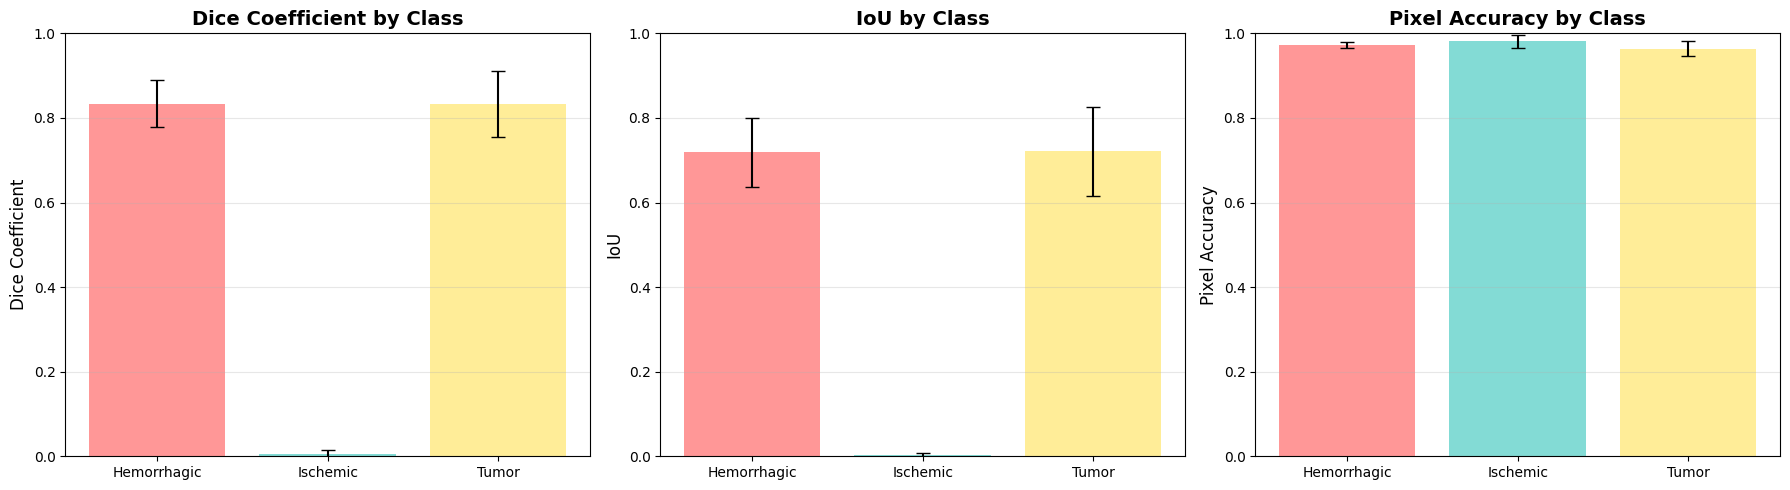

In [66]:
# Visualize metrics per class
metrics_names = ['dice', 'iou', 'acc']
metric_labels = ['Dice Coefficient', 'IoU', 'Pixel Accuracy']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (metric, label) in enumerate(zip(metrics_names, metric_labels)):
    means = [np.mean(evaluation_metrics[cls][metric]) for cls in CLASSES]
    stds = [np.std(evaluation_metrics[cls][metric]) for cls in CLASSES]
    
    x_pos = np.arange(len(CLASSES))
    axes[idx].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, color=['#FF6B6B', '#4ECDC4', '#FFE66D'])
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(CLASSES)
    axes[idx].set_ylabel(label, fontsize=12)
    axes[idx].set_title(f'{label} by Class', fontsize=14, fontweight='bold')
    axes[idx].set_ylim([0, 1.0])
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

### ResUNet Hybrid Segmentation Model:
- **Architecture**: Residual U-Net with skip connections
- **Training**: Weakly-supervised using pseudo-masks from K-Means
- **Loss Function**: Hybrid (BCE + Dice Loss)
- **Applications**: 
  - Lesion segmentation for hemorrhagic, ischemic, and tumor cases
  - Feature extraction for downstream classification
  - Attention mechanism in concept-based models

### Next Steps:
1. Integrate with classification model for end-to-end pipeline
2. Use segmentation masks as attention for concept bottleneck model
3. Fine-tune on manually annotated data if available